## Simulated m.bovis population in Ireland

- used to test various tools

In [2]:
import sys,os,subprocess
from importlib import reload
import numpy as np
import pandas as pd
import pylab as plt
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO,AlignIO
from Bio import Phylo
import seaborn as sns
import toytree
import snipgenie
from snipgenie import app,trees, tools, snp_typing

## phastsim to create sequences from phylogeny

In [ ]:
refseq = SeqIO.read('Mbovis_AF212297.fa','fasta')
scale = (10/len(refseq))
#scale=8e-6
print (scale)
def run_phastsim():
    cmd = 'phastSim --outpath phastsim_output/ --seed 1 --createFasta' \
             ' --createPhylip --treeFile sim.newick' \
             ' --scale {s} --invariable .1 --alpha 1.0 --omegaAlpha 1.0' \
             ' --reference Mbovis_AF212297.fa'.format(s=scale)
    subprocess.check_output(cmd, shell=True)

In [ ]:
from Bio import Phylo
tree = Phylo.read('/storage/btbgenie/simpop/sim.newick', "newick")
tree
#Phylo.draw(tree)
#myclade = tree.find_clades("1").next()
t1 = tree.common_ancestor(['4','31'])
Phylo.draw(t1)
cl = t1.find_clades("4")
x=t1.find_clades(terminal=True)
for i in x:
    print (i)

In [ ]:
#add more sequences to make more clusters within simulated samples
result = []
seqs = list(SeqIO.parse('sim_mbovis.fa','fasta'))
l=len(seqs)+1
mseqs = random.sample(seqs,6)
for rec in mseqs:
    #number in 'cluster'
    c = random.randint(1,6)
    for i in range(c):
        seq = rec.seq.tomutable()
        #number of mutations
        muts = random.randint(2,8)
        for m in range(muts):
            site = random.randint(1, len(seq)-1)      
            seq[site] = random.choice(list('ATCG'))
        new = SeqRecord(seq, id=str(l))
        l+=1
        #print (new)
        result.append(new)

print (len(result))

In [218]:
SeqIO.write(result,'sim_mbovis_extra.fa','fasta')

25

In [ ]:
def make_fastq(ref, outfile, cmp=100):
    f1 = '/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_16-12-19/19-1230_S81_L001-4_R1_001.fastq.gz'
    f2 = '/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_16-12-19/19-1230_S81_L001-4_R2_001.fastq.gz'
    cmd = 'java -jar /local/ArtificialFastqGenerator/ArtificialFastqGenerator.jar -O {o}'\
          ' -R {r} -S ">temp" -RL 150 -CMP {cmp} -CSD 0.2 -SE true'.format(r=ref, o=outfile,cmp=cmp,f1=f1,f2=f2) #-URQS true -F1 {f1} -F2 {f2}
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    return

def generate_fastqs(infile, outpath):
    
    from joblib import Parallel, delayed
    import multiprocessing, time
    num_cores = 4
    
    simrecs = list(SeqIO.parse(infile,'fasta'))
    def my_func(rec):
        from tempfile import mkstemp
        x,tmp = mkstemp()
        SeqIO.write(SeqRecord(rec.seq,id='temp'), tmp, 'fasta')
        out = os.path.join(outpath,rec.id)
        make_fastq(tmp, out)

    st = time.time()
    #Parallel(n_jobs=num_cores)(delayed(my_func)(i) for i in simrecs)
    #print (time.time()-st)
    for i in simrecs:
        my_func(i)        
        cmd = 'pigz %s/*.fastq' %outpath
        subprocess.check_output(cmd, shell=True)
    
generate_fastqs('sim_mbovis_extra.fa', 'sim_fastq')

In [87]:
def generate_fastq_entry(sequence, index):
    """ 
    Head contains: Instrument name, run ID, flowcell ID, flowcell lane,
     tile number within flowcell lane, x-coordinate, y-coordinate,
     member of a pair (1 or 2), filtered or not (Y or N), control bits, index sequence
     Assuming best quality Phred score for Illumina 1.8+
    """
    
    header = "@FAKE-SEQ:1:FAKE-FLOWCELL-ID:1:1:0:"+str(index)+"#0/1"
    s = ''
    quality = len(sequence) * 'I'
    s += header+'\n'
    s += sequence+'\n'
    s += '+'+'\n'
    s += quality+'\n'
    #print (s)
    return s

def generate_fastq_PE(ref_fasta, filename='test', reads=100, length=150):
    """
    Function generates a set of paired-end reads. The first read maps to the
     forward strand and the second on the reverse strand. 
    """

    dna = SeqIO.read(ref_fasta, 'fasta').seq
    #dna = dna[:2000]
    filename1 = filename+'_1.fastq'
    filename2 = filename+'_2.fastq'
    f1 = open(filename1,'w',encoding = 'utf-8')
    f2 = open(filename2,'w',encoding = 'utf-8')    
    for pos in np.random.randint(1,len(dna),reads):
        ins_size = np.random.randint(200,500)
        end = pos+ins_size
        seq1 = str(dna[pos:pos+length])
        seq2 = str(dna[end-length:end].reverse_complement())
        s1 = generate_fastq_entry(seq1, pos)
        s2 = generate_fastq_entry(seq2, pos)
        f1.write(s1)
        f2.write(s2)
        
    for f in [filename1,filename2]:
        cmd = 'pigz --force %s' %f
        subprocess.check_output(cmd, shell=True)
    return 


In [88]:
generate_mapped_fastq_PE(app.mbovis_genome, reads=1000000)

## run snipgenie on simulated fastqs

In [ ]:
args = {'threads':12, 'outdir': 'sim_results', 'labelsep':'.',
        'input':['sim_fastq'], 'overwrite':True,
         'species':'Mbovis-AF212297',        
         'custom_filters': True,
         'buildtree':True}
W = snipgenie.app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
tresnps = toytree.tree('sim_results/tree.newick')
#tresnps=tresnps.root('2')
tresnps=tresnps.drop_tips('ref')
canvas,t,r=tresnps.draw(layout='c',scalebar=True,height=700,width=700,tip_labels_style={"font-size":"15px"})

## add locations on map to samples 

- related samples get same counties/area
- simulate moves by randomly changing locations of some samples

In [222]:
import geopandas as gpd
import random
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

In [223]:
counties = gpd.read_file('https://github.com/dmnfarrell/snipgenie/raw/master/maps/ireland_counties.zip?raw=true')
#vals = counties.NAME_TAG.unique()
countyvals=['Cork','Kerry','Clare','Tipperary','Wicklow','Monaghan','Roscommon','Waterford','Mayo','Down','Fermanagh']

## add random locations

In [224]:
from shapely.geometry import Point
def random_point_in_shp(x):
    shp = counties[counties.NAME_TAG==x.county].iloc[0]
    within = False
    bounds = shp.geometry.bounds    
    while within is False:
        x = np.random.uniform(bounds[0], bounds[2])
        y = np.random.uniform(bounds[1], bounds[3])        
        within = shp.geometry.contains(Point(x, y))       
    return x,y

(-10.924406855, -5.165025645, 51.18654548, 55.63761892)

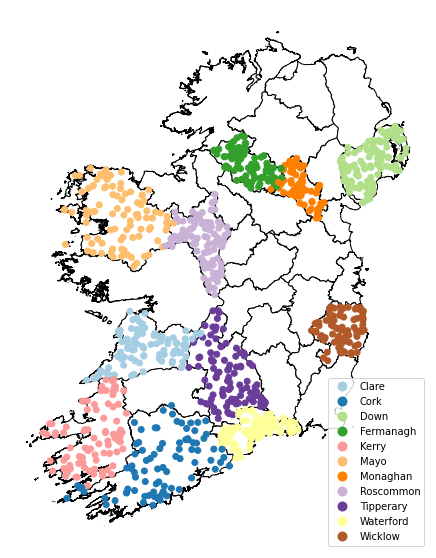

In [225]:
#random fake farm locations
farms = pd.DataFrame({'herd_no':range(1000),'county':r})
farms['county'] = farms.apply(lambda x: random.choice(countyvals),1)
farms['coord'] = farms.apply(random_point_in_shp,1)
farms[['LONG','LAT']] = pd.DataFrame(farms.coord.tolist(), index=farms.index)
farms = gpd.GeoDataFrame(farms, geometry=gpd.points_from_xy(farms.LONG, farms.LAT),crs='EPSG:4326')
fig,ax=plt.subplots(1,1,figsize=(10,10))
counties.plot(ax=ax,color='white',ec='black')
farms.plot(ax=ax,column='county',cmap='Paired',legend=True)
ax.axis('off')

In [226]:
meta = pd.read_csv('sim_results/samples.csv')
meta = meta[['sample']]
meta['species'] = 'Cow'
meta = meta.astype(str)
clusts = trees.get_clusters('sim_results/tree.newick')
meta = meta.merge(clusts,left_on='sample',right_on='SequenceName')

clades = list(clusts.snp100.unique()[1:])
mapdict = dict(zip(clades,vals))
    
meta['county'] = meta['snp100'].map(mapdict).fillna('Monaghan')
meta = meta.astype(str)


TreeCluster.py  -i sim_results/tree.newick -t 3 -m max_clade
TreeCluster.py  -i sim_results/tree.newick -t 5 -m max_clade
TreeCluster.py  -i sim_results/tree.newick -t 7 -m max_clade
TreeCluster.py  -i sim_results/tree.newick -t 10 -m max_clade
TreeCluster.py  -i sim_results/tree.newick -t 12 -m max_clade
TreeCluster.py  -i sim_results/tree.newick -t 20 -m max_clade
TreeCluster.py  -i sim_results/tree.newick -t 50 -m max_clade
TreeCluster.py  -i sim_results/tree.newick -t 100 -m max_clade


In [227]:
meta['coord'] = meta.apply(random_point_in_shp,1)


In [228]:
def simulate_moves():
    for i,r in meta.iterrows():
        #print (r.county)
        new = farms.sample().iloc[0]
        #print (new)
        p = np.random.random()
        if p>0.8:           
            meta.at[i,'county'] = new.county    
            meta.at[i,'coord'] = new.coord
simulate_moves()
meta

,sample,species,SequenceName,snp10,snp100,snp12,snp20,snp3,snp5,snp50,snp7,county,coord
0,1,Cow,1,-1,-1,-1,-1,-1,-1,-1,-1,Monaghan,"(-6.942064397063582, 54.285877513667124)"
1,10,Cow,10,-1,6,-1,-1,-1,-1,-1,-1,Cork,"(-8.164602145916877, 51.80810209313456)"
2,100,Cow,100,-1,2,-1,-1,-1,-1,3,-1,Kerry,"(-9.940998786830091, 51.959054064015106)"
3,101,Cow,101,-1,2,-1,-1,-1,-1,3,-1,Kerry,"(-9.364169499036187, 52.21951952241558)"
4,102,Cow,102,1,2,2,2,-1,-1,2,-1,Kerry,"(-9.737877521372429, 52.09017590521416)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,95,Cow,95,-1,2,-1,-1,-1,-1,19,-1,Kerry,"(-9.460789954599326, 52.42721481891031)"
212,96,Cow,96,-1,2,-1,-1,-1,-1,20,-1,Kerry,"(-9.32247281021249, 52.22659577745993)"
213,97,Cow,97,-1,2,-1,15,-1,-1,9,-1,Down,"(-6.350130003141675, 54.365068032031864)"
214,98,Cow,98,-1,2,-1,-1,-1,-1,10,-1,Kerry,"(-10.322166390801794, 52.139986506983)"


(-10.924406855, -5.165025645, 51.18654548, 55.63761892)

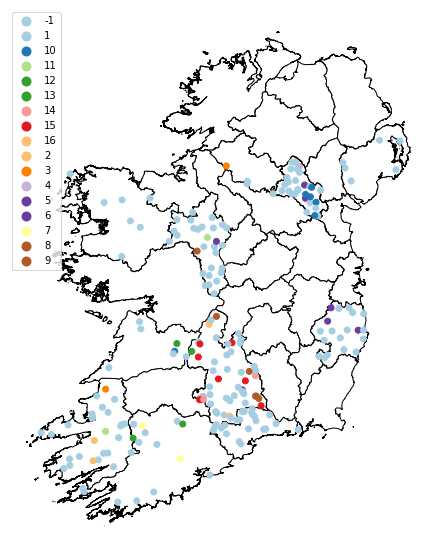

In [235]:
meta[['LONG','LAT']] = pd.DataFrame(meta.coord.tolist(), index=meta.index)
gdf = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(meta.LONG, meta.LAT),crs='EPSG:4326')
fig,ax=plt.subplots(1,1,figsize=(10,10))
counties.plot(ax=ax,color='white',ec='black')
gdf.plot(ax=ax,column='snp12',cmap='Paired',legend=True)
ax.axis('off')

In [231]:
meta.to_csv('/storage/btbgenie/simpop/sim_metadata.csv')

In [239]:
import pyvolve
my_tree = pyvolve.read_tree(file = "sim.newick")
my_model = pyvolve.Model("nucleotide")
my_partition = pyvolve.Partition(models = my_model, root_sequence = "GATAGAAC")
my_evolver = pyvolve.Evolver(partitions = my_partition, tree = my_tree)
my_evolver() # evolve sequences

# Define an Evolver instance to evolve several partitions
#my_multpart_evolver = pyvolve.Evolver(partitions = [partition1, partition2, partition3], tree = my_tree)
#my_multpart_evolver() # evolve sequences

In [ ]:
my_evolver.evolved_seqs